**Avant de débuter ce TP** :

1. **Changez le type d'exécution sur Google Colab** : `Exécution > Modifiez le type d'exécution > T4 GPU`
2. **Installez les paquets ci-dessous** :

In [1]:
! pip install lightning torchmetrics torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 828.5/828.5 kB 29.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 65.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.4/832.4 kB 67.0 MB/s eta 0:00:00


3. Exécutez ce code pour supprimer quelques messages et avertissements éventuellement affichés.

In [2]:
import logging
logging.getLogger("lightning").setLevel(logging.ERROR)
logging.getLogger("lightning.pytorch.utilities.rank_zero").setLevel(logging.WARNING)
logging.getLogger("lightning.pytorch.accelerators.cuda").setLevel(logging.WARNING)
logger = logging.getLogger("lightning")
logger.propagate = False

import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")

# *Inpainting* d'images masquées

Dans ce notebook, vous allez travailler sur le jeu de données [MNIST](https://en.wikipedia.org/wiki/MNIST_database) constitué d'images de chiffres manuscrits.

L'[*inpainting*](https://fr.wikipedia.org/wiki/Inpainting) consiste à reconstruire des images détériorées ou à remplir des parties manques des images.
L'exemple ci-dessous est tiré de la page Wikipedia concernant l'*inpainting*.
À gauche se trouve l'image détériorée et à droite se trouve l'image reconstruite.

<img src="https://upload.wikimedia.org/wikipedia/commons/f/f8/Restoration.jpg" width=800 />

**L'objectif est de reconstruire les images à partir des images détériorées.**

## Téléchargement et visualisation des données

La fonction `load_dataset()` définie ci-dessous permet de télécharger le jeu de données.

In [3]:
import torch


def load_dataset(train, path="data"):
    """Charge le jeu de données.

    Parameters
    ----------
    train : bool
        Si True, renvoie le jeu d'entraînement. Sinon, renvoie le jeu de validation.

    path : str
        Chemin du répertoire où charger ou télécharger le jeu de données.

    Returns
    -------
    X : Tensor, shape = (n_observations, 1, hauteur, largeur)
        Images originales.
    """
    from torchvision.datasets import MNIST

    # Télécharge les données
    dataset = MNIST(root=path, download=True, train=train)

    # Formate le tenseur
    X = torch.unsqueeze(dataset.data / 255, 1)

    return X

Il suffit d'appeler cette fonction pour récupérer les jeux d'entraînement et de validation.

In [4]:
X_train_original = load_dataset(train=True)
X_val_original = load_dataset(train=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 21.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 510kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.63MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 10.5MB/s]


### Question 1

Déterminez le nombre d'observations dans les jeux d'entraînement et de validation.
Déterminez (par du code) la taille de chaque observation (on admettra que toutes les observations ont la même taille, il suffit donc de calculer la taille d'une seule observation).

In [7]:
# TODO
print(f'Le nombre d\'observations du jeu d\'entrainement est :  {len(X_train_original)}')
print(f'Le nombre d\'observations du jeu de validation est :  {len(X_val_original)}')
print(f'La taille d\'une observation est :  {X_train_original[0].shape}')

Le nombre d'observations du jeu d'entrainement est :  60000
Le nombre d'observations du jeu de validation est :  10000
La taille d'une observation est :  torch.Size([1, 28, 28])


### Question 2

Quelles sont les valeurs minimale et maximale des pixels sur le jeu d'entraînement ?

In [9]:
# TODO
print(f'La valeur minimale des pixels sur le jeu d\'entrainement est :  {torch.min(X_train_original)}')
print(f'La valeur maximale des pixels sur le jeu d\'entrainement est :  {torch.max(X_train_original)}')

La valeur minimale des pixels sur le jeu d'entrainement est :  0.0
La valeur maximale des pixels sur le jeu d'entrainement est :  1.0


Le jeu de données ne contient que les images originales (non-détériorées).
Il va donc falloir implémenter notre propre technique de détérioration d'images.
Nous allons implémenter quelque chose de simple : chaque pixel est remplacé, avec une probabilité $p$, par un pixel noir (c'est-à-dire un pixel dont la valeur est $0.0$).
Une implémentation possible de cette approche est la suivante :

1. Générer un tenseur de variables aléatoires uniformes sur l'intervalle $[0, 1]$ de la même forme que le tenseur d'entrées. Pour ce faire, vous pouvez utiliser la fonction [`torch.rand_like()`](https://docs.pytorch.org/docs/stable/generated/torch.rand_like.html).
2. Transformer ce tenseur de variables aléatoires uniformes en un masque, c'est-à-dire un tenseur de booléens, indiquant quels éléments du tenseur d'entrée garder : les éléments gardés sont ceux dont la variable aléatoire uniforme est supérieure à $p$.
3. Multiplier le tenseur d'entrées par le masque : les éléments pour lesquels le masque vaut `True` sont gardés, et les éléments pour lesquels le masque vaut `False` sont remplacés par $0$.


La fonction `deteriorate_images()` définie ci-dessous permet d'effectuer cette détérioration.

### Question 3

Complétez le code manquant dans la fonction `deteriorate_images()`.

In [10]:
def deteriorate_images(images, p=0.5):
    """Détériore des images.

    Parameters
    ----------
    images : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images originales.

    p : float, default = 0.5
        Probabilité de remplacer chaque pixel par un pixel noir.

    Returns
    -------
    images_masked : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images détériorées.
    """
    ### BEGIN TODO ###
    tensor_random = torch.rand_like(images)
    mask = tensor_random > p
    images_masked = images * mask
    ### END TODO
    return images_masked

On appelle maintenant la fonction `deteriorate_images()`, avec `p=0.5`, pour créer des images détériorées sur les jeux d'entraînement et de validation :

In [11]:
X_train_deteriorated = deteriorate_images(X_train_original)
X_val_deteriorated = deteriorate_images(X_val_original)

La fonction `plot_original_and_deteriorated_images()` définie ci-dessous permet de visualiser cette opération : elle prend en entrée un lot d'images originales, applique la transformation et affiche les images originales et détériorées.

In [12]:
import matplotlib.pyplot as plt


def plot_original_and_deteriorated_images(images_original, images_deteriorated):
    """Affiche les images originales et les images détériorées.

    Parameters
    ----------
    images_original : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images originales.

    images_deteriorated : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images détériorées.
    """
    # Récupère le nombre d'images
    n_images = images_original.shape[0]

    # Initialise la figure
    plt.figure(figsize=(6.5, 3 * n_images))

    # Pour chaque ligne
    for row in range(n_images):

        # Affiche l'image originale
        plt.subplot(n_images, 2, 1 + row * 2)
        plt.imshow(images_original[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image originale")
        plt.axis("off");

        # Affiche l'image détériorée
        plt.subplot(n_images, 2, 2 + row * 2)
        plt.imshow(images_deteriorated[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image détériorée")
        plt.axis("off");

### Question 4

Appelez la fonction `plot_original_and_deteriorated_images()` pour afficher quelques images originales et détériorées des jeux d'entraînement et de validation.

In [16]:
X_train_original[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

In [17]:
X_train_deteriorated[0]

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,

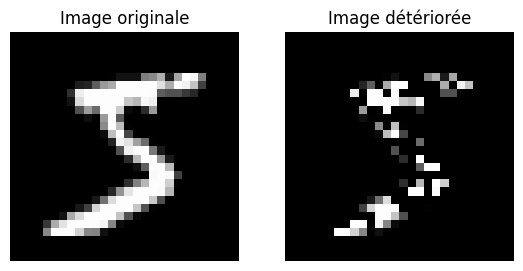

In [21]:
# TODO
plot_original_and_deteriorated_images(X_train_original[0].unsqueeze(0), X_train_deteriorated[0].unsqueeze(0))

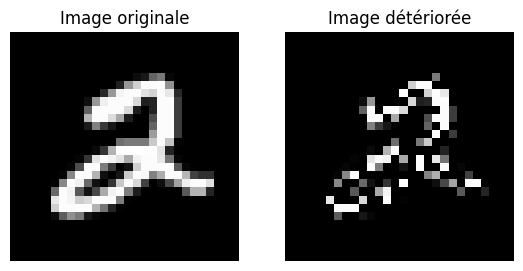

In [22]:
# TODO
# TODO
plot_original_and_deteriorated_images(X_train_original[5].unsqueeze(0), X_train_deteriorated[5].unsqueeze(0))

Nous allons évaluer la performance des modèles avec l’erreur quadratique moyenne (*mean squared error*) :
$$
  \text{MSE} = \frac{1}{n H W} \sum_{i=1}^n \sum_{j=1}^H \sum_{k=1}^W \left( X_{i, j, k} - \hat{X}_{i, j, k} \right)^2
$$
où $n$ est le nombre d'images, $H$ est la hauteur (c'est-à-dire le nombre de lignes) et $W$ est la largeur (c'est-à-dire le nombre de colonnes).


Un modèle vraiment trivial consiste à ne prédire que des images noires (c'est-à-dire dont tous les pixels sont égaux à $0.0$) :
$$
    \forall i, j, k, \; \hat{X}_{i, j, k} = 0.0
$$

### Question 5

Calculez les erreurs quadratiques moyennes sur les jeux d'entraînement et de validation pour cette approche. On rappelle que :

* l'opérateur *puissance* en Python s'obtient avec deux étoiles : `2.0 ** 3` veut dire $2.0^3$ ; cet opérateur fonctionne également sur les tenseurs et applique la puissance à chaque élément du tenseur ;
* on peut calculer la valeur moyenne d'un tenseur avec la méthode [`torch.Tensor.mean()`](https://docs.pytorch.org/docs/stable/generated/torch.Tensor.mean.html) ou la fonction [`torch.mean()`](https://docs.pytorch.org/docs/stable/generated/torch.mean.html).

In [26]:
# TODO
mse_train = torch.mean(X_train_original**2)
mse_val = torch.mean(X_val_original**2)
print(f'MSE sur le jeu d\'entrainement : {mse_train}')
print(f'MSE sur le jeu de validation : {mse_val}')

MSE sur le jeu d'entrainement : 0.11200257390737534
MSE sur le jeu de validation : 0.11395809799432755


Un autre modèle trivial consiste à garder les images détériorées telles quelles.

### Question 6

Calculez les erreurs quadratiques moyennes sur les jeux d'entraînement et de validation pour cette approche.

In [34]:
# TODO
mse_deteriorated_train = torch.mean((X_train_original - X_train_deteriorated)**2)
mse_deteriorated_val = torch.mean((X_val_original - X_val_deteriorated)**2)


print(f'MSE sur le jeu d\'entrainement des images détériorées : {mse_deteriorated_train}')
print(f'MSE sur le jeu de validation des images détériorées : {mse_deteriorated_val}')

MSE sur le jeu d'entrainement des images détériorées : 0.0560038685798645
MSE sur le jeu de validation des images détériorées : 0.05698854476213455


In [36]:
import torch.nn as nn

criterion = nn.MSELoss()  # on crée l'instance

mse_train2 = criterion(X_train_deteriorated, X_train_original)
print(f'MSE sur le jeu d\'entrainement : {mse_train2}')
mse_val2 = criterion(X_val_deteriorated, X_val_original)
print(f'MSE sur le jeu de validation : {mse_val2}')

MSE sur le jeu d'entrainement : 0.0560038685798645
MSE sur le jeu de validation : 0.05698854476213455


Avant d'entraîner un réseau de neurones, nous allons essayons une approche simple.
Nous allons utiliser un noyau de floutage uniforme : on remplace la valeur de chaque pixel par la moyenne uniforme de son pixel et de ses pixels voisins.
La fonction `box_blur_convolution()` définie ci-dessous implémente cette approche.

In [28]:
def box_blur_convolution(images_deteriorated, kernel_size=3):
    """

    Parameters
    ----------
    images_deteriorated : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images détériorées.

    kernel_size : int, default = 3
        Taille du noyau. Doit être un entier impair supérieur ou égal à 3.

    Returns
    -------
    images_convolved : Tensor, shape = (n_images, 1, hauteur, largeur)

    """
    if not (isinstance(kernel_size, int) and (kernel_size > 2) and (kernel_size % 2 == 1)):
        raise ValueError("'kernel_size' doit être un entier impair supérieur ou égal à 3.")

    kernel = torch.ones(1, 1, kernel_size, kernel_size) / kernel_size ** 2
    conv = torch.nn.Conv2d(1, 1, kernel_size, padding="same", bias=False)
    conv.weight = torch.nn.Parameter(kernel, requires_grad=False)
    images_convolved = conv(images_deteriorated)
    return images_convolved

On appelle cette fonction pour appliquer la transformation sur les jeux d'entraînement et de validation :

In [29]:
X_train_reconstructed = box_blur_convolution(X_train_deteriorated)
X_val_reconstructed = box_blur_convolution(X_val_deteriorated)

### Question 7

Calculez les erreurs quadratiques moyennes sur ces deux jeux.

In [42]:
import torch.nn as nn

criterion = nn.MSELoss()  # on crée l'instance

mse_train2 = criterion(X_train_reconstructed, X_train_original)
print(f'MSE sur le jeu d\'entrainement : {mse_train2}')
mse_val2 = criterion(X_val_reconstructed, X_val_original)
print(f'MSE sur le jeu de validation : {mse_val2}')

MSE sur le jeu d'entrainement : 0.04470924660563469
MSE sur le jeu de validation : 0.04513917490839958


On définit la fonction `plot_original_deteriorated_reconstructed_images()` pour afficher des images originales, des images détériorées et des images reconstruites.

In [43]:
def plot_original_deteriorated_reconstructed_images(
    images_original, images_deteriorated, images_reconstructed
):
    """Affiche les images originales, les images détériorées et les images reconstruites.

    Parameters
    ----------
    images_original : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images originales.

    images_deteriorated : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images détériorées.

    images_reconstructed : Tensor, shape = (n_images, 1, hauteur, largeur)
        Images reconstruites.
    """
    # Récupère le nombre d'images
    n_images = images_original.shape[0]

    # Initialise la figure
    plt.figure(figsize=(6.5, 3 * n_images))

    # Pour chaque ligne
    for row in range(n_images):

        # Affiche l'image originale
        plt.subplot(n_images, 3, 1 + row * 3)
        plt.imshow(images_original[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image originale")
        plt.axis("off");

        # Affiche l'image détériorée
        plt.subplot(n_images, 3, 2 + row * 3)
        plt.imshow(images_deteriorated[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image détériorée")
        plt.axis("off");

        # Affiche l'image reconstruite
        plt.subplot(n_images, 3, 3 + row * 3)
        plt.imshow(images_reconstructed[row, 0], cmap="gray", vmin=0.0, vmax=1.0)
        plt.title("Image reconstruite")
        plt.axis("off");

### Question 8

Appelez la fonction `plot_original_deteriorated_reconstructed_images()` pour afficher des images originales, des images détériorées et des images reconstruites sur le jeu de validation. Que constatez-vous ?

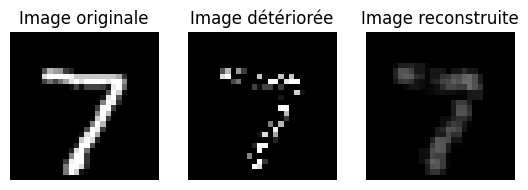

In [44]:
# TODO
plot_original_deteriorated_reconstructed_images(X_val_original[0].unsqueeze(0), X_val_deteriorated[0].unsqueeze(0), X_val_reconstructed[0].unsqueeze(0))

[texte du lien](https:// [texte du lien](https://))**Réponse** : TODO


On constate que les images les images sont de plus en plus floues. La distribution de pixels après chaque transformation diminue.

### Question 9

Pour confirmer votre réponse à la question précédente, affichez la distribution des pixels des images originales d'une part et des images reconstruites d'autre part, sur le jeu d'entraînement.
Vous pouvez utiliser la fonction [`matplotlib.pyplot.hist()`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.hist.html).

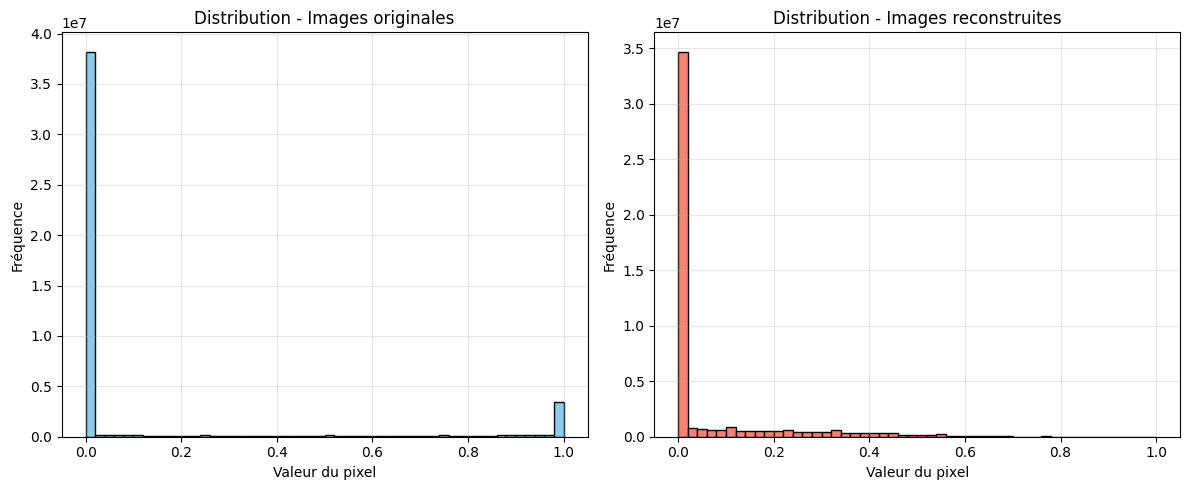

In [50]:
# TODO


import matplotlib.pyplot as plt
import torch

# Création d'une figure avec 2 sous-graphiques côte à côte
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Distribution des images originales
axes[0].hist(X_train_original.flatten().numpy(), bins=50, color='skyblue', edgecolor='black')
axes[0].set_title("Distribution - Images originales", fontsize=12)
axes[0].set_xlabel("Valeur du pixel", fontsize=10)
axes[0].set_ylabel("Fréquence", fontsize=10)
axes[0].grid(alpha=0.3)

# Distribution des images détériorées
axes[1].hist(X_train_reconstructed.flatten().numpy(), bins=50, color='salmon', edgecolor='black')
axes[1].set_title("Distribution - Images reconstruites", fontsize=12)
axes[1].set_xlabel("Valeur du pixel", fontsize=10)
axes[1].set_ylabel("Fréquence", fontsize=10)
axes[1].grid(alpha=0.3)

# Espacement harmonieux
plt.tight_layout()
plt.show()




Pour essayer de remédier à ce problème, nous allons normaliser les images pour que la valeur maximale des pixels de chaque image reconstruite soit égale à $1.0$. Pour ce faire, on va simplement diviser chaque pixel d'une image reconstruite par la valeur maximale des pixels de cette image reconsruite.

### Question 10

1. Appliquez cette transformation aux images reconstruites des jeux d'entraînement et d'évaluation.
2. Affichez la nouvelle distribution des pixels sur le jeu d'entraînement.
3. Affichez quelques images reconstruites normalisées sur le jeu de validation avec la fonction `plot_original_deteriorated_reconstructed_images()`.
4. Calculez les erreurs quadratiques moyennes sur les deux jeux.
5. Commentez les résultats obtenus.

Pour répondre à la première question, vous pouvez utiliser la fonction [`torch.amax()`](https://docs.pytorch.org/docs/stable/generated/torch.amax.html) ou la méthode [`torch.Tensor.amax()`](https://docs.pytorch.org/docs/stable/generated/torch.Tensor.amax.html).
Lisez la documentation, notamment pour les paramètres `dim` et `keepdim`.
Il est possible de répondre à la question sans boucle `for` grâce au [*broadcasting*](https://docs.pytorch.org/docs/stable/notes/broadcasting.html).

In [61]:
# TODO
train_max_values = torch.amax(X_train_reconstructed, dim=(2, 3), keepdim=True)
X_train_reconstructed_normalized = X_train_reconstructed / train_max_values
val_max_values = torch.amax(X_val_reconstructed, dim=(2, 3), keepdim=True)
X_val_reconstructed_normalized = X_val_reconstructed / val_max_values

Text(0, 0.5, 'Fréquence')

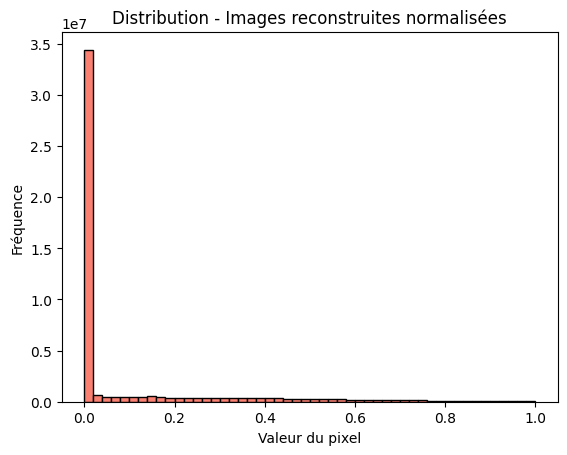

In [59]:
# TODO

plt.hist(X_train_reconstructed_normalized.flatten().numpy(), bins=50, color='salmon', edgecolor='black')
plt.title("Distribution - Images reconstruites normalisées", fontsize=12)
plt.xlabel("Valeur du pixel", fontsize=10)
plt.ylabel("Fréquence", fontsize=10)

In [ ]:
# TODO

In [62]:
mse_train2 = criterion(X_train_reconstructed_normalized, X_train_original)
print(f'MSE sur le jeu d\'entrainement : {mse_train2}')
mse_val2 = criterion(X_val_reconstructed_normalized, X_val_original)
print(f'MSE sur le jeu de validation : {mse_val2}')

MSE sur le jeu d'entrainement : 0.03154091164469719
MSE sur le jeu de validation : 0.03188515082001686


In [ ]:
# TODO

**Réponse** : TODO

Nous allons maintenant essayer une autre approche un peu plus avancée pour rendre la distribution des pixels des images reconstruites plus proche de celles des pixels des images originales.
Pour cela, nous allons utiliser la **transformation par quantiles**.

Sur le jeu d'entraînement, on apprend :
* $T_1$ : la transformation qui passe de la distribution des pixels des images originales à une distribution uniforme, et
* $T_2$ : la transformation qui passe de la distribution des pixels des images reconstruites à une distribution uniforme.

Ensuite, pour transformer les images reconstruites afin que la distribution de leurs pixels suive la distribution des pixels des images originales, on applique la transformation $T_1^{-1} \circ T_2$ aux images reconstruites.

Le code ci-dessous applique ces transformations sur les jeux d'entraînement et d'évaluation :

In [63]:
from sklearn.preprocessing import QuantileTransformer


qt_train_original = QuantileTransformer(n_quantiles=100, subsample=None)
qt_train_reconstructed = QuantileTransformer(n_quantiles=100, subsample=None)

qt_train_original.fit(X_train_original.ravel().view(-1, 1))
qt_train_reconstructed.fit(X_train_reconstructed.ravel().view(-1, 1))

X_train_reconstructed_quantile = qt_train_original.inverse_transform(
    qt_train_reconstructed.transform(X_train_reconstructed.ravel().view(-1, 1))
).reshape(X_train_reconstructed.shape)

X_val_reconstructed_quantile = qt_train_original.inverse_transform(
    qt_train_reconstructed.transform(X_val_reconstructed.ravel().view(-1, 1))
).reshape(X_val_reconstructed.shape)

### Question 11

1. Affichez la nouvelle distribution des pixels sur le jeu d'entraînement.
2. Affichez quelques images reconstruites transformées sur le jeu de validation avec la fonction `plot_original_deteriorated_reconstructed_images()`.
3. Calculez les erreurs quadratiques moyennes sur les deux jeux.
4. Commentez les résultats obtenus.

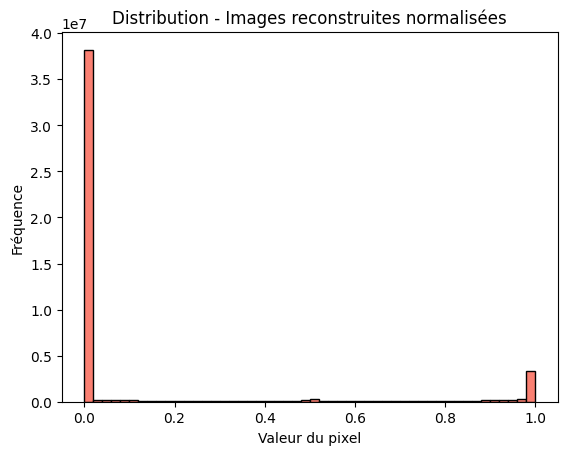

In [66]:
# TODO

plt.hist(X_train_reconstructed_quantile.flatten(),
         bins=50, color='salmon', edgecolor='black')
plt.title("Distribution - Images reconstruites par transformation par quantiles", fontsize=12)
plt.xlabel("Valeur du pixel", fontsize=10)
plt.ylabel("Fréquence", fontsize=10)
plt.show()



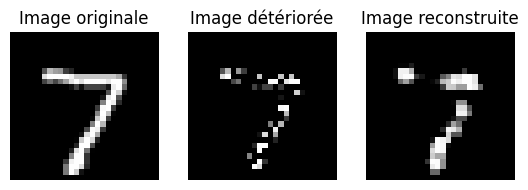

In [71]:
# TODO
# Convertir en tenseur PyTorch et ajouter la dimension batch
reconstructed_img = torch.tensor(X_val_reconstructed_quantile[0]).unsqueeze(0)

plot_original_deteriorated_reconstructed_images(
    X_val_original[0].unsqueeze(0),
    X_val_deteriorated[0].unsqueeze(0),
    reconstructed_img
)


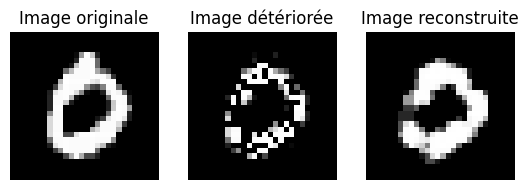

In [72]:
reconstructed_img = torch.tensor(X_val_reconstructed_quantile[3]).unsqueeze(0)

plot_original_deteriorated_reconstructed_images(
    X_val_original[3].unsqueeze(0),
    X_val_deteriorated[3].unsqueeze(0),
    reconstructed_img
)

In [74]:
# TODO


# Convertir en tenseurs PyTorch
X_train_reconstructed_t = torch.tensor(X_train_reconstructed_quantile, dtype=torch.float32)
X_val_reconstructed_t   = torch.tensor(X_val_reconstructed_quantile, dtype=torch.float32)

# Calcul MSE
mse_train2 = criterion(X_train_reconstructed_t, X_train_original)
mse_val2   = criterion(X_val_reconstructed_t, X_val_original)

print(f"MSE sur le jeu d'entraînement : {mse_train2.item():.4f}")
print(f"MSE sur le jeu de validation  : {mse_val2.item():.4f}")



MSE sur le jeu d'entraînement : 0.0264
MSE sur le jeu de validation  : 0.0262


On observe l'image reconstruite par la transformation par quantile a une meilleure résolution que celle avec la transformation normalisée. Les MSE train et MSE val sont presques identiques, et plus faibles à tous les autres MSE précedents.

**Réponse** : TODO

Nous allons maintenant essayer une approche par réseaux de neurones convolutifs.

### Question 12

Créez les *dataloaders* pour les jeux d'entraînement et de validation en utilisant la classe [`torch.utils.data.DataLoader()`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) avec des lots de taille $32$. N'oubliez pas de mélanger (*shuffle*) les observations pour le jeu d'entraînement, mais pas pour le jeu de validation. Pour créer les jeux de données, utiliser la classe [`torch.utils.data.TensorDataset()`](https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.TensorDataset). **Chaque jeu de données doit contenir à la fois les images détériorées et les images originales**.

In [75]:
# TODO

from torch.utils.data import DataLoader

dataset_train = torch.utils.data.TensorDataset(X_train_deteriorated, X_train_original)
dataset_val = torch.utils.data.TensorDataset(X_val_deteriorated, X_val_original)


dataloader_train = DataLoader(dataset_train, batch_size=32, shuffle=True)
dataloader_val = DataLoader(dataset_val, batch_size=32)


## Architecture

Nous allons utiliser une architecture de type auto-encodeur, composée d'un encodeur et d'un décodeur.

L'encodeur aura l'architecture séquentielle suivante :

* Convolution en deux dimensions avec $32$ canaux en sortie, un noyau de taille $3 \times 3$ et du rembourrage (*padding*) de $1$.
* Fonction d'activation ReLU.
* Regroupement par le maximum avec un noyau de taille $2 \times 2$.
* Convolution en deux dimensions avec $16$ canaux en sortie, un noyau de taille $3 \times 3$ et du rembourrage (*padding*) de $1$.
* Fonction d'activation ReLU.
* Regroupement par le maximum avec un noyau de taille $2 \times 2$.
* Convolution en deux dimensions avec $8$ canaux en sorties, un noyau de taille $3 \times 3$ et du rembourrage (*padding*) de $1$.
* Fonction d'activation ReLU.
* Regroupement par le maximum avec un noyau de taille $2 \times 2$.

Le décodeur aura l'architecture séquentielle suivante :

* Convolution transposée avec $8$ canaux en sortie, un noyau de taille $3 \times 3$ et un pas (*stride*) de taille $2$.
* Fonction d'activation ReLU.

* Convolution transposée avec $16$ canaux en sortie, un noyau de taille $2 \times 2$ et un pas (*stride*) de taille $2$.
* Fonction d'activation ReLU.

* Convolution transposée avec $32$ canaux en sortie, un noyau de taille $2 \times 2$ et un pas (*stride*) de taille $2$.
* Fonction d'activation ReLU.

* Convolution avec $1$ canal en sortie, un noyau de taille $3 \times 3$ et du rembourrage (*padding*) de $1$.
* Fonction d'activation sigmoïde.

Voici les liens vers les documentations des classes pertinentes :
[`torch.nn.Conv2d()`](https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html),
[`torch.nn.ReLU()`](https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html),
[`torch.nn.MaxPool2d()`](https://pytorch.org/docs/stable/generated/torch.nn.MaxPool2d.html),
[`torch.nn.ConvTranspose2d()`](https://pytorch.org/docs/stable/generated/torch.nn.ConvTranspose2d.html) et
[`torch.nn.Sigmoid()`](https://pytorch.org/docs/stable/generated/torch.nn.Sigmoid.html).

        
### Question 13

Complétez le code manquant dans les méthodes `__init__()`, `forward()`, `step()` et `configure_optimizers()` de la classe `DenoisingAutoencoder()` avec les informations suivantes :
* `__init__()` : il faut définir la fonction de perte (`self.loss`) : on utilisera l'erreur quadratique moyenne ; il faut initialiser toutes les couches.
* `forward()` : il faut définir la passe avant, c'est-à-dire comment passer des entrées (les images détériorées) aux sorties (les images reconstruites).
* `step()` : étant donné un lot d'observations (`batch`), il faut :
    + récupérer les entrées (les images détériorées) et les vraies sorties (les images originales),
    + faire une passe avant pour récupérer les images reconstruites,
    + calculer la fonction de coût entre les images reconstruites et les images originales (`loss`).
* `configure_optimizers()` : on utilisera l'algorithme d'optimisation *Adam* avec les valeurs par défaut pour ses hyperparamètres.

In [1]:
import lightning as L


class DenoisingAutoencoder(L.LightningModule):

    def __init__(self):
        """Constructeur.

        Dans le constructeur, on exécute le constructeur de la clase mère et on définit
        toutes les couches et fonctions d'activation de notre réseau de neurones.
        """
        super().__init__()  # Toujours exécuter le constructeur de la classe mère

        ### BEGIN TODO ###
        # Initialisation de la fonction de perte
        self.loss = nn.MSELoss()

        # Encodeur
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(32, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        # Décodeur
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 8, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(8, 16, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 1, kernel_size=3, padding=1),
            nn.Sigmoid()
        )

        # Initialisation de toutes les couches

        #### END TODO ####

    def forward(self, X_deteriorated):
        ### BEGIN TODO ###
        X_encoded = self.encoder(X_deteriorated)
        X_predicted = self.decoder(X_encoded)
        #### END TODO ###
        return X_predicted

    def step(self, batch, dataset):
        X_original, X_deteriorated = batch
        ### BEGIN TODO ###
        X_predicted = self.forward(X_deteriorated)
        loss = self.loss(X_predicted, X_original)
        #### END TODO ###

        name = "train" if dataset=="training" else "val"
        bar_step = dataset=="training"

        self.log(f"loss_{name}", loss, prog_bar=bar_step, on_step=bar_step, on_epoch=True)
        return loss

    def training_step(self, batch):
        """Effectue une étape d'entraînement."""
        return self.step(batch, "training")

    def validation_step(self, batch):
        """Effectue une étape de validation."""
        return self.step(batch, "validation")

    def on_train_start(self):
        """Code exécuté au début de l'entraînement."""
        string = f"Version {self.trainer.logger.version}"
        print(f"{string}\n{'=' * len(string)}\n")

    def on_train_epoch_end(self):
        """Code exécuté à la fin de chaque époque d'entraînement."""
        metrics = self.trainer.callback_metrics
        string = (f"""
            Époque {self.trainer.current_epoch + 1} / {self.trainer.max_epochs}
            ------------------------------------
            |     Jeu      | Fonction de perte |
            | ------------ | ----------------- |
            | Entraînement |{metrics['loss_train'].item():^19.5f}|
            |  Validation  |{metrics['loss_val'].item():^19.5f}|
            ------------------------------------
        """)
        string = '\n'.join([line.strip() for line in string.strip().split('\n')])
        print(string, '\n')

    def configure_optimizers(self):
        """Configure l'algorithme d'optimisation à utiliser."""
        ### BEGIN TODO ###
        optimizer = torch.optim.Adam(self.parameters())
        #### END TODO ####
        return optimizer

ModuleNotFoundError: No module named 'lightning'

### Question 14

Affichez un résumé de votre architecture. Combien de paramètres entraînables a-t-elle ?

In [79]:
# TODO
!pip install torchsummary
from torchsummary import summary


model = DenoisingAutoencoder()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
summary(model, input_size=(1, 28, 28))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
              ReLU-2           [-1, 32, 28, 28]               0
         MaxPool2d-3           [-1, 32, 14, 14]               0
            Conv2d-4           [-1, 16, 14, 14]           4,624
              ReLU-5           [-1, 16, 14, 14]               0
         MaxPool2d-6             [-1, 16, 7, 7]               0
            Conv2d-7              [-1, 8, 7, 7]           1,160
              ReLU-8              [-1, 8, 7, 7]               0
         MaxPool2d-9              [-1, 8, 3, 3]               0
  ConvTranspose2d-10              [-1, 8, 7, 7]             584
             ReLU-11              [-1, 8, 7, 7]               0
  ConvTranspose2d-12           [-1, 16, 14, 14]             528
             ReLU-13           [-1, 16, 14, 14]               0
  ConvTranspose2d-14           [-1, 32,

**Réponse** :   On a 9585 paramètres entrainables.

### Question 15

Entraînez votre modèle pendant $10$ époques.

In [82]:
import lightning as L
from lightning.pytorch.loggers import CSVLogger
from lightning.pytorch.callbacks import TQDMProgressBar

# Instanciation du modèle
model = DenoisingAutoencoder()

# Instanciation du Trainer
trainer = L.Trainer(
    max_epochs=10,
    enable_model_summary=False,
    logger=CSVLogger("."),
    num_sanity_val_steps=0,
    callbacks=[TQDMProgressBar(refresh_rate=100)]
)

# Entraînement
trainer.fit(
    model=model,
    train_dataloaders=dataloader_train,
    val_dataloaders=dataloader_val
)


MisconfigurationException: No `training_step()` method defined. Lightning `Trainer` expects as minimum a `training_step()`, `train_dataloader()` and `configure_optimizers()` to be defined.

On récupère toutes les images reconstruites par le réseau de neurones artificiels sur le jeu de validation :

In [ ]:
X_val_reconstructed_dae = model(X_val_deteriorated).detach()

### Question 16

En utilisant la fonction `plot_original_deteriorated_reconstructed_images()`, affichez quelques images reconstruites par le réseau de neurones artificiels sur le jeu de validation.

In [ ]:
# TODO

### Question 17

Quel est le meilleur modèle parmi les différentes approches essayées ? Justifiez votre réponse.

**Réponse** : TODO